# RTL-SDR Basics

- https://github.com/roger-/pyrtlsdr
- https://inst.eecs.berkeley.edu/~ee123/sp15/python_install.html
- Error-12 solved after reinstalling rtl-sdr driver in zadig (choose Composite): https://github.com/jopohl/urh/issues/389
- Executed in WinEluk "cvision"

# Signal Detection with CNN: {wfm, tv, gsm, dmr, others}

- wfm: Wide FM
- dmr: Digital Mobile Radio
- gsm: European stardard for mobile communication

- https://github.com/randaller/cnn-rtlsdr

## Load sample RF data saved in pickle's format

- Ref: https://github.com/randaller/cnn-rtlsdr
- train_ji.py



## Define the class DataSet & loading functions

In [25]:
import time
import os
import glob
from sklearn.utils import shuffle
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline


def load_data(train_path, classes):
    samples = []
    labels = []
    sample_names = []
    cls = []

    for fields in classes:
        index = classes.index(fields)
        path = os.path.join(train_path, fields, '*.npy')
        files = glob.glob(path)
        for fl in files:
            iq_samples = np.load(fl)

            real = np.real(iq_samples)
            imag = np.imag(iq_samples)

            # iq_samples = np.concatenate((real, imag))
            # iq_samples = np.reshape(iq_samples, (-1, 2, 3200))

            iq_samples = []
            for i in range(0, np.ma.count(real) - 212):  # 128*192 magic
                iq_samples.append(real[i])
                iq_samples.append(imag[i])
            iq_samples = np.reshape(iq_samples, (-1, 128, 2))

            samples.append(iq_samples)

            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            sample_names.append(flbase)
            cls.append(fields)

    samples = np.array(samples)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    cls = np.array(cls)

    return samples, labels, sample_names, cls


class DataSet(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]


def read_train_sets(train_path, classes, validation_size):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, img_names, cls = load_data(train_path, classes)
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]

    data_sets.train = DataSet(train_images, train_labels, train_img_names, train_cls)
    data_sets.valid = DataSet(validation_images, validation_labels, validation_img_names, validation_cls)

    return data_sets


In [2]:
# Understanding: Load train
train_path = '/home/jaime/Dropbox-LCN/jisoft_LARGE/0_data_RTL_SDR/training_data'

classes = [d for d in os.listdir(train_path)]

tic = time.time()
print('Loading data. It might take a while...')
images, labels, img_names, cls = load_data(train_path, classes)
toc = time.time()
print('Time elapsed to load data: %d seconds'%(toc-tic))

Loading data. It might take a while...
Time elapsed to load data: 30 seconds


In [3]:
print(images.shape)
print(labels.shape)
print(labels)
print(cls)

(4990, 96, 128, 2)
(4990, 5)
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]
['wfm' 'wfm' 'wfm' ..., 'dmr' 'dmr' 'dmr']


Text(0.5,1,'Sample signal at time t')

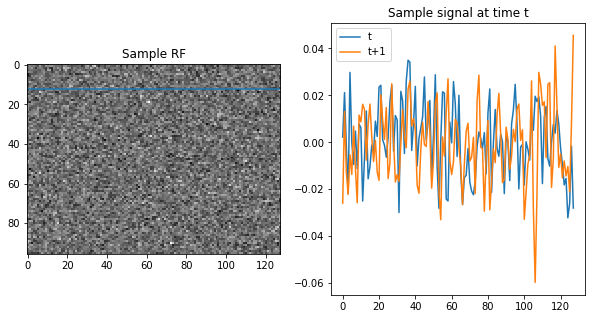

In [4]:
# Visualize iq sample
t = 12
fig , axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].imshow(images[111,:,:,0],cmap='gray')
axes[0].plot(range(128),t*np.ones([128,1]))
axes[0].set_title('Sample RF')
axes[1].plot(images[111,t,:,0])
axes[1].plot(images[111,t+1,:,0])
axes[1].legend(['t','t+1'])
axes[1].set_title('Sample signal at time t')

## Load dataset

In [5]:
#import dataset
import tensorflow as tf
import os
import time
from datetime import timedelta
import math
import random
import numpy as np

batch_size = 16
num_inputs = 2

train_path = '/home/jaime/Dropbox-LCN/jisoft_LARGE/0_data_RTL_SDR/training_data'

classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
num_classes = len(classes)

data = read_train_sets(train_path, classes, validation_size=0.3)

In [6]:
data.train.images.shape

(3493, 96, 128, 2)

## CNN in Pytorch

In [7]:
# Set library
# Library
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# Set random seed --> just to replicate experiment!
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [8]:
# Set CPU or GPU device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu") 
print('cuda:', use_cuda)

cuda: True


In [9]:
# >> NOTE: log_softmax + NLLLoss == CrossEntropyLoss <<
# https://discuss.pytorch.org/t/is-log-softmax-nllloss-crossentropyloss/9352

In [10]:
# Define the CNN Architecture

from torch.autograd import Variable
import torch.nn.functional as F

#num_filters_conv1 = 32
#num_filters_conv2 = 32
#num_filters_conv3 = 64
#fc_layer_size = 128

# 2 Conv layers
nhidden = [32,32,32] # number of channels/filters 
ndense = 128 # #neurons of dense layer

# Basic CNN
class CNN3(torch.nn.Module):
    
    # Our batch shape for input x are images (2, 128,96) --> 2d with 2 channels
    # Output: 5 classes
    
    def __init__(self):
        super(CNN3, self).__init__()
        
        # Layer conv1: 2 --> nhidden[0] channels
        self.conv1 = torch.nn.Conv2d(2, nhidden[0], kernel_size=3, stride=1, padding=1)
        
        # MaxPool: stride=2 will make jump 2-by-2
        #          number of channels will not change
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Layer conv2: In: nhidden[0] --> Out: nhidden[1]
        self.conv2 = torch.nn.Conv2d(nhidden[0], nhidden[1], kernel_size=3, stride=1, padding=1)
        
        # MaxPool: stride=2 will make jumpt 2-by-2
        #          number of channels will not change
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Layer conv3: In: nhidden[1] --> Out: nhidden[2]
        self.conv3 = torch.nn.Conv2d(nhidden[1], nhidden[2], kernel_size=3, stride=1, padding=1)
        
        # MaxPool: stride=2 will make jumpt 2-by-2
        #          number of channels will not change
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        
        # DenseLayer1: flatten the previous output
        # Input: nhidden[2]*(96/2/2/2=12, 128/2^3=16) --> Output: ndense
        self.fc1 = torch.nn.Linear(nhidden[2] *12*16, ndense)
        
        # Denselayer2
        # Input: ndense
        # Output: 5
        self.fc2 = torch.nn.Linear(ndense, 5)
        
    def forward(self, x):
        
        # Computes the activation of conv1
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Computes the activation of conv2
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Computes the activation of conv3
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Reshape data to input to the input layer of the neural net
        # Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, nhidden[2] * 12*16)
        
        # Computes the activation of the first fully connected layer
        x = F.relu(self.fc1(x))        
        # Add dropout: recommended after linear transformation (dense)
        # Ref: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
        x = F.dropout(x,p=0.5, training=self.training)

        #Computes the second fully connected layer (activation applied later)
        x = self.fc2(x)
        
        return x
        #return(F.log_softmax(x,dim=1)) # USE THIS IF NOT USING 
        # ==> log_softmax + NLLLoss == CrossEntropyLoss

In [11]:
# Set Optimizer and Loss

import torch.optim as optim

# Function makes easy to recall functions for different NN models :)
def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss() # ==> log_softmax + NLLLoss == CrossEntropyLoss
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

Text(0.5,1,'Number of samples in each class')

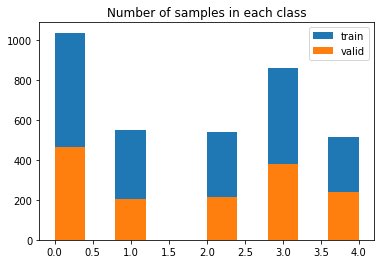

In [12]:
a = np.argmax(data.train.labels,axis=1)
b = np.argmax(data.valid.labels,axis=1)
plt.hist(a)
plt.hist(b)
plt.legend(['train','valid'])
plt.title('Number of samples in each class')

In [13]:
# Prepare data
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler

## SHORT way ##

# Reshape: nsamples,96,128,2 --> nsamples,2,128,96
# Channel has to be the 2nd dim!
X_train = np.swapaxes(data.train.images,1,3)
X_val = np.swapaxes(data.valid.images,1,3)
print(X_train.shape,X_val.shape)

XY_train = data_utils.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(np.argmax(data.train.labels,axis=1)).long())
XY_val = data_utils.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(np.argmax(data.valid.labels,axis=1)).long())

# Prepare DataLoader
train_sampler = SubsetRandomSampler(np.arange(len(XY_train), dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(len(XY_val), dtype=np.int64))
# Train loader. It takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(XY_train, batch_size=batch_size,
                                           sampler=train_sampler)
    return(train_loader)

# Test and validation loaders have constant batch sizes, so we can define them directly
#test_loader = torch.utils.data.DataLoader(XY_test, batch_size=4, sampler=test_sampler, num_workers=2)
#val_loader = torch.utils.data.DataLoader(XY_val, batch_size=128, sampler=val_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(XY_val, batch_size=50, sampler=val_sampler)

allval = [[i,j] for [i,j] in val_loader]
                                  

(3493, 2, 128, 96) (1497, 2, 128, 96)


In [14]:
# TRAINING

import time
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def trainNet(net, batch_size, n_epochs, learning_rate):
    all_loss_train = []
    all_loss_val = []
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 5
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data # data are in torch tensor format
            
            #Wrap them in a Variable object (NO NEED... THEY ARE ALREADY TENSORS...)
            #inputs, labels = Variable(inputs), Variable(labels)
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            #print(outputs.shape,type(outputs))
            #print(labels.shape,type(labels))
            loss_size = loss(outputs, labels) # outputs is in one-hot format [n_batches, n_classes] 
                                              # labels should be indices [n_batches]
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            #running_loss += loss_size.data[0]
            #total_train_loss += loss_size.data[0]
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        allf1 = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:

                #Wrap tensors in Variables
                #inputs, labels = Variable(inputs), Variable(labels)
                inputs, labels = inputs.to(device), labels.to(device)

                #Forward pass
                val_outputs = net(inputs)
                val_loss_size = loss(val_outputs, labels)
                #total_val_loss += val_loss_size.data[0]
                total_val_loss += val_loss_size.data.item()

                # Report classification accuracy
                #y_true = np.array(labels) # this works because 'labels' does not have gradients associated
                y_true = labels.cpu().numpy() # bring to CPU and then convert to numpy
                _, y_pred = torch.max(val_outputs,1)
                #y_pred = y_pred.detach().cpu().numpy() # just another way to converto to np
                y_pred = y_pred.cpu().numpy() # just another way to converto to np

                #print('y_true:',y_true)
                #print('y_pred:',y_pred)
                #print(classification_report(y_true, y_pred, target_names=list(classes)))
                allf1.append(f1_score(y_true, y_pred,average="macro"))
                                     
        print("Validation loss = %.2f, F1-score(macro): %.2f"%(total_val_loss / len(val_loader), np.mean(allf1)))
        # Store
        all_loss_train.append(total_train_loss/len(train_loader))
        all_loss_val.append(total_val_loss/len(val_loader))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    with torch.no_grad():     
        print("\n ===== Sample result from a validation data ==== \n")
        
        inputs = allval[0][0]
        labels = allval[0][1]

        #Wrap tensors in Variables
        #inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        #Forward pass
        val_outputs = net(inputs)
        val_loss_size = loss(val_outputs, labels)
        total_val_loss += val_loss_size.data.item()

        # Report classification accuracy
        #y_true = np.array(labels) # this works because 'labels' does not have gradients associated
        y_true = labels.cpu().numpy() # bring to CPU and then convert to numpy
        _, y_pred = torch.max(val_outputs,1)
        #y_pred = y_pred.detach().cpu().numpy() # just another way to converto to np
        y_pred = y_pred.cpu().numpy() # just another way to converto to np

        #print('y_true:',y_true)
        #print('y_pred:',y_pred)
        print(classification_report(y_true, y_pred, target_names=list(classes)))
        
    return all_loss_train, all_loss_val

In [15]:
torch.cuda.empty_cache()

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 100
learning_rate= 0.001
Epoch 1, 20% 	 train_loss: 1.61 took: 0.51s
Epoch 1, 41% 	 train_loss: 1.13 took: 0.49s
Epoch 1, 62% 	 train_loss: 0.86 took: 0.50s
Epoch 1, 83% 	 train_loss: 0.83 took: 0.49s


/home/jaime/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation loss = 0.75, F1-score(macro): 0.52
Epoch 2, 20% 	 train_loss: 0.75 took: 0.49s
Epoch 2, 41% 	 train_loss: 0.73 took: 0.49s
Epoch 2, 62% 	 train_loss: 0.67 took: 0.49s
Epoch 2, 83% 	 train_loss: 0.69 took: 0.49s
Validation loss = 0.52, F1-score(macro): 0.64
Epoch 3, 20% 	 train_loss: 0.54 took: 0.49s
Epoch 3, 41% 	 train_loss: 0.59 took: 0.49s
Epoch 3, 62% 	 train_loss: 0.52 took: 0.49s
Epoch 3, 83% 	 train_loss: 0.48 took: 0.49s
Validation loss = 0.51, F1-score(macro): 0.66
Epoch 4, 20% 	 train_loss: 0.51 took: 0.49s
Epoch 4, 41% 	 train_loss: 0.40 took: 0.49s
Epoch 4, 62% 	 train_loss: 0.45 took: 0.49s
Epoch 4, 83% 	 train_loss: 0.58 took: 0.49s
Validation loss = 0.47, F1-score(macro): 0.68
Epoch 5, 20% 	 train_loss: 0.44 took: 0.49s
Epoch 5, 41% 	 train_loss: 0.47 took: 0.49s
Epoch 5, 62% 	 train_loss: 0.56 took: 0.49s
Epoch 5, 83% 	 train_loss: 0.49 took: 0.49s
Validation loss = 0.44, F1-score(macro): 0.74
Epoch 6, 20% 	 train_loss: 0.52 took: 0.49s
Epoch 6, 41% 	 train_l

/home/jaime/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Validation loss = 0.44, F1-score(macro): 0.75
Epoch 14, 20% 	 train_loss: 0.43 took: 0.49s
Epoch 14, 41% 	 train_loss: 0.40 took: 0.49s
Epoch 14, 62% 	 train_loss: 0.36 took: 0.50s
Epoch 14, 83% 	 train_loss: 0.35 took: 0.49s
Validation loss = 0.43, F1-score(macro): 0.74
Epoch 15, 20% 	 train_loss: 0.36 took: 0.50s
Epoch 15, 41% 	 train_loss: 0.32 took: 0.50s
Epoch 15, 62% 	 train_loss: 0.33 took: 0.50s
Epoch 15, 83% 	 train_loss: 0.37 took: 0.49s
Validation loss = 0.57, F1-score(macro): 0.67
Epoch 16, 20% 	 train_loss: 0.40 took: 0.53s
Epoch 16, 41% 	 train_loss: 0.33 took: 0.54s
Epoch 16, 62% 	 train_loss: 0.34 took: 0.55s
Epoch 16, 83% 	 train_loss: 0.34 took: 0.53s
Validation loss = 0.35, F1-score(macro): 0.79
Epoch 17, 20% 	 train_loss: 0.33 took: 0.52s
Epoch 17, 41% 	 train_loss: 0.31 took: 0.49s
Epoch 17, 62% 	 train_loss: 0.35 took: 0.49s
Epoch 17, 83% 	 train_loss: 0.39 took: 0.52s
Validation loss = 0.46, F1-score(macro): 0.73
Epoch 18, 20% 	 train_loss: 0.38 took: 0.50s
Epoch

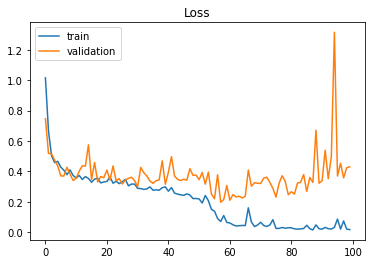

In [18]:
# Run the training
CNN = CNN3()

if use_cuda:
    CNN.to(device)
    
all_loss_train, all_loss_val = trainNet(CNN, batch_size=32, n_epochs=100, learning_rate=0.001)

plt.plot(all_loss_train)
plt.plot(all_loss_val)
plt.title('Loss')
plt.legend(['train','validation'])
plt.show()

In [19]:
# SAVE TRAINED MODEL
torch.save(CNN.state_dict(), '0_models_pytorch/cnn3_july27.pt')

## Running saved models

In [21]:
# LOAD THE SAVED MODEL AND TEST
model = CNN3()
model.load_state_dict(torch.load('0_models_pytorch/cnn3_july27.pt'))

In [27]:
# Load test data

dpath = '/home/jaime/Dropbox-LCN/jisoft_LARGE/0_data_RTL_SDR/testing_data'

classes = [d for d in os.listdir(dpath)]

tic = time.time()
print('Loading data. It might take a while...')
images, labels, img_names, cls = load_data(dpath, classes)
toc = time.time()
print('Time elapsed to load data: %d seconds'%(toc-tic))

Loading data. It might take a while...
Time elapsed to load data: 15 seconds


(2490, 96, 128, 2) (2490, 5)


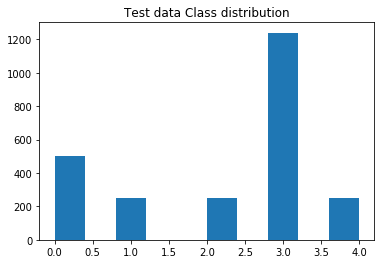

In [30]:
# onehot to indices
y_test = np.argmax(labels,axis=1)
plt.hist(y_test)
plt.title('Test data Class distribution')
print(images.shape,labels.shape)

In [32]:
# Prepare data
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler

## SHORT way ##

# Reshape: nsamples,96,128,2 --> nsamples,2,128,96
# Channel has to be the 2nd dim!
X_test = np.swapaxes(images,1,3)
print(X_test.shape)

XY_test = data_utils.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

# Prepare DataLoader
test_sampler = SubsetRandomSampler(np.arange(len(XY_test), dtype=np.int64))
test_loader = torch.utils.data.DataLoader(XY_test, batch_size=100, sampler=test_sampler)

alltest = [[i,j] for [i,j] in test_loader]

(2490, 2, 128, 96)


In [35]:
# RUN TEST

import time
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

device = torch.device("cpu")
model.to(device) # just use the CPU

with torch.no_grad():
    allf1 = []
    for inputs, labels in test_loader:

        #Wrap tensors in Variables
        #inputs, labels = Variable(inputs), Variable(labels) # NOT NEEDED
        
        inputs, labels = inputs.to(device), labels.to(device)

        #Forward pass
        test_outputs = model(inputs)
        
        # Report classification accuracy
        #y_true = np.array(labels) # this works because 'labels' does not have gradients associated
        y_true = labels.cpu().numpy() # bring to CPU and then convert to numpy
        _, y_pred = torch.max(test_outputs,1)
        #y_pred = y_pred.detach().cpu().numpy() # just another way to converto to np
        y_pred = y_pred.cpu().numpy() # just another way to converto to np

        #print('y_true:',y_true)
        #print('y_pred:',y_pred)
        #print(classification_report(y_true, y_pred, target_names=list(classes)))
        allf1.append(f1_score(y_true, y_pred,average="macro"))

print("Test average F1-score(macro): %.2f"%(np.mean(allf1)))

with torch.no_grad():     
    print("\n ===== Sample result from a test data ==== \n")

    inputs = alltest[0][0]
    labels = alltest[0][1]

    #Wrap tensors in Variables
    #inputs, labels = Variable(inputs), Variable(labels)
    inputs, labels = inputs.to(device), labels.to(device)

    #Forward pass
    test_outputs = model(inputs)
    
    # Report classification accuracy
    #y_true = np.array(labels) # this works because 'labels' does not have gradients associated
    y_true = labels.cpu().numpy() # bring to CPU and then convert to numpy
    _, y_pred = torch.max(test_outputs,1)
    #y_pred = y_pred.detach().cpu().numpy() # just another way to converto to np
    y_pred = y_pred.cpu().numpy() # just another way to converto to np

    print(classification_report(y_true, y_pred, target_names=list(classes)))

Test average F1-score(macro): 0.93

 ===== Sample result from a test data ==== 

             precision    recall  f1-score   support

        wfm       1.00      0.94      0.97        18
         tv       0.89      0.89      0.89         9
        gsm       0.88      1.00      0.93         7
      other       0.98      0.98      0.98        52
        dmr       1.00      1.00      1.00        14

avg / total       0.97      0.97      0.97       100



## (Code in TF from randller)

In [ ]:
session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, 96, 128, num_inputs], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))


def create_convolutional_layer_tim(input, num_input_channels, conv_filter_size1, conv_filter_size2, num_filters):
    weights = create_weights(shape=[conv_filter_size1, conv_filter_size2, num_input_channels, num_filters])
    biases = create_biases(num_filters)
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases
    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = tf.nn.relu(layer)
    # layer = tf.nn.dropout(layer, 0.5)
    return layer


def create_convolutional_layer(input, num_input_channels, conv_filter_size, num_filters):
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    biases = create_biases(num_filters)
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases
    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer = tf.nn.relu(layer)
    return layer


def create_flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features])
    return layer


def create_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer


'''
layer_conv1 = create_convolutional_layer(input=x,
                                         num_input_channels=num_inputs,
                                         conv_filter_size=filter_size_conv1,
                                         num_filters=num_filters_conv1)

layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                         num_input_channels=num_filters_conv1,
                                         conv_filter_size=filter_size_conv2,
                                         num_filters=num_filters_conv2)

layer_conv3 = create_convolutional_layer(input=layer_conv2,
                                         num_input_channels=num_filters_conv2,
                                         conv_filter_size=filter_size_conv3,
                                         num_filters=num_filters_conv3)
'''
# Tim O'Shea network   https://arxiv.org/pdf/1602.04105.pdf
layer_conv1 = create_convolutional_layer_tim(input=x,
                                             num_input_channels=num_inputs,
                                             conv_filter_size1=1,
                                             conv_filter_size2=3,
                                             num_filters=64)

layer_conv3 = create_convolutional_layer_tim(input=layer_conv1,
                                             num_input_channels=64,
                                             conv_filter_size1=2,
                                             conv_filter_size2=3,
                                             num_filters=16)

layer_flat = create_flatten_layer(layer_conv3)

layer_fc1 = create_fc_layer(input=layer_flat, num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=fc_layer_size, use_relu=True)

layer_fc2 = create_fc_layer(input=layer_fc1, num_inputs=fc_layer_size, num_outputs=num_classes, use_relu=False)

y_pred = tf.nn.softmax(layer_fc2, name='y_pred')
y_pred_cls = tf.argmax(y_pred, axis=1)
session.run(tf.global_variables_initializer())

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
session.run(tf.global_variables_initializer())


def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0}, Train Acc: {1:>6.1%}, Val Acc: {2:>6.1%}, Val Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))


saver = tf.train.Saver()
# loading pre-trained model to continue training
if (os.path.exists('checkpoint')):
    #saver.restore(session, tf.train.latest_checkpoint('./'))
    saver.restore(session, tf.train.latest_checkpoint('./'))

batch_size = 16
for i in range(0, 25000):

    x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
    x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)

    feed_dict_tr = {x: x_batch, y_true: y_true_batch}
    feed_dict_val = {x: x_valid_batch, y_true: y_valid_batch}

    session.run(optimizer, feed_dict=feed_dict_tr)

    if i % int(data.train.num_examples / batch_size) == 0:
        val_loss = session.run(cost, feed_dict=feed_dict_val)
        epoch = int(i / int(data.train.num_examples / batch_size))

        show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
        saver.save(session, './rtlsdr-model')